<a href="https://colab.research.google.com/github/SianC7/LAIDS/blob/main/1D_CNN_baseline_model(%2Bquant).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CICIDS2017 Dataset

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
import pandas as pd

# --- Data Collection ---

# Set pandas display options for wide output
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)


# Get Data file path
file_path = '/content/drive/MyDrive/Colab Notebooks/Honours Project/Datasets/cicids2017_cleaned.csv'
cicids2017_df = pd.read_csv(file_path, sep=",", comment="#", header=0)
cicids2017_df.columns = cicids2017_df.columns.str.strip()  # Strip whitespace from column names


print("\nInitial samples:")
print(f"cicids2017_df shape: {cicids2017_df.shape}")
# print(cicids2017_df.head().to_string())
# print(cicids2017_df.info())

# Print unique values and their counts for 'Attack Type'
print("\nAttack Type Distribution:")
print(cicids2017_df['Attack Type'].value_counts())

# --- Label Encoding ---

cicids2017_df['Attack Type'] = cicids2017_df['Attack Type'].apply(lambda x: 0 if x == 'Normal Traffic' else 1)


Initial samples:
cicids2017_df shape: (2520751, 53)

Attack Type Distribution:
Attack Type
Normal Traffic    2095057
DoS                193745
DDoS               128014
Port Scanning       90694
Brute Force          9150
Web Attacks          2143
Bots                 1948
Name: count, dtype: int64


# Train/val/test split

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# --- Train/val/test split ---
# Split label from datafram
X = cicids2017_df.drop('Attack Type', axis=1)
y = cicids2017_df['Attack Type']

# Split Data
X_temp, X_test, y_temp, y_test= train_test_split(X, y, test_size=0.3, random_state=42, stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42, stratify = y_temp)

# Shuffle the data
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_val, y_val = shuffle(X_val, y_val, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)


Visualisation of data split

Input Shapes -> Train: (1411620, 52), Val: (352905, 52), Test: (756226, 52)
Labels[Benign, Mal] -> Train: [1173231  238389], Val: [293308  59597], Test: [628518 127708]


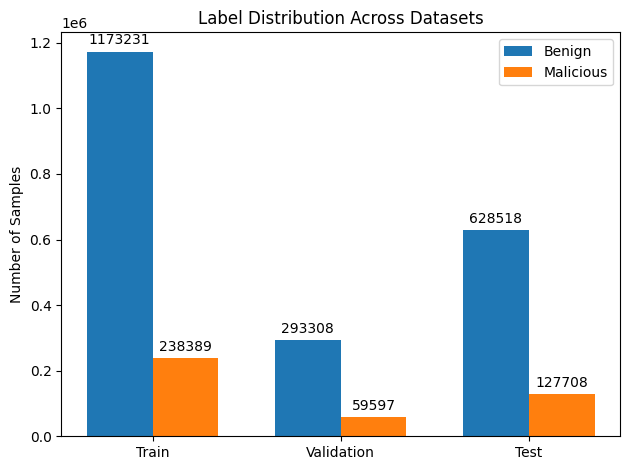

In [34]:
import numpy as np
import matplotlib.pyplot as plt

print(f"Input Shapes -> Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
print(f"Labels[Benign, Mal] -> Train: {np.bincount(y_train)}, Val: {np.bincount(y_val)}, Test: {np.bincount(y_test)}")

train_counts = np.bincount(y_train)
val_counts = np.bincount(y_val)
test_counts = np.bincount(y_test)

# Data for plotting
labels = ['Benign', 'Malicious']
datasets = ['Train', 'Validation', 'Test']
counts = [train_counts, val_counts, test_counts]

# Transpose counts to group by label
benign_counts = [c[0] for c in counts]
mal_counts = [c[1] for c in counts]

x = np.arange(len(datasets))  # the label locations
width = 0.35  # width of the bars

# Plot
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, benign_counts, width, label='Benign')
rects2 = ax.bar(x + width/2, mal_counts, width, label='Malicious')

# Add labels
ax.set_ylabel('Number of Samples')
ax.set_title('Label Distribution Across Datasets')
ax.set_xticks(x)
ax.set_xticklabels(datasets)
ax.legend()

# Add value labels
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),  # vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

#Normalise the datasets

In [35]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
import numpy as np

# --- Normalize ---
#scaler = RobustScaler() # Initialize the scaler
scaler = StandardScaler() # Initialize the scaler

# Apply the scaler
X_train = scaler.fit_transform(X_train) # Standardise data features
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Print the shape of the scaled data to verify
print(f"Shape of X_train after scaling: {X_train.shape}")
print(f"Shape of X_val after scaling: {X_val.shape}")
print(f"Shape of X_test after scaling: {X_test.shape}")

Shape of X_train after scaling: (1411620, 52)
Shape of X_val after scaling: (352905, 52)
Shape of X_test after scaling: (756226, 52)


# Data reshaping for 1D CNN input

In [36]:
import numpy as np

# Reshape the data for 1D CNN input
# 1D CNN expects input shape: (samples, timesteps, features). timesteps = number of features, features = 1 (per timestep)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


# --- Final Shape Confirmation ---
print("Training input shape:", X_train.shape)
print("Validation input shape:", X_val.shape)
print("Test input shape:", X_test.shape)

Training input shape: (1411620, 52, 1)
Validation input shape: (352905, 52, 1)
Test input shape: (756226, 52, 1)


#1D CNN model

In [37]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Input

# Define the 1D CNN Model

# Define input shape
input_shape = (X_train.shape[1], 1)  # (timesteps, features)

# Build model
model = Sequential([
    Input(shape=input_shape),

    Conv1D(filters=64, kernel_size=3, activation='relu'), # Detect patterns in the network traffic data
    BatchNormalization(), # Normalizes the outputs of a the Conv1D layer before passing them to the MaxPool layer
    MaxPooling1D(pool_size=2), # Reduce the dimensions of the data without affecting key features
    Dropout(0.25), # Prevent overfitting by forcing the model to generalize - it does this by randomly deactivating a fraction of neurons during training

    Conv1D(filters=128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.25),

    Conv1D(filters=128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Flatten(), # Converts the output of the last Conv1D layer into a 1D vector for the fully connected layers
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)), # Apply L2 regularisation to prevent overfitting (common in the dense layer) #https://medium.com/@bhatadithya54764118/day-49-overfitting-and-underfitting-in-dl-regularization-techniques-8ded20baa3d6
    Dropout(0.3), # Randomly drop 50% of the network's neurons to further prevent overfitting
    Dense(1, activation='sigmoid')  # Final output layer( 1 = 1 neuron for binary classification, sigmoid = decides if input is malicious (1) or benign (0))
])

# Compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # Loss function measures how well the model’s predictions match true labels

#Summary
#model.summary()

In [38]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Input

# #Step 3: Define the 1D CNN Model

# # Input shape
# input_shape = (X_train.shape[1], 1)  # input_shape = (time_steps, features) of the training data

# # Build model
# CNN_model = Sequential([
#     Input(shape=input_shape),
#     Conv1D(filters=32, kernel_size=3, activation='relu'),   # Learn 32 distinct patterns from the data -> try detect low-level, local patterns from raw features
#     BatchNormalization(),                                   # Normalizes the outputs of a the Conv1D layer before passing them to the MaxPool layer
#     MaxPooling1D(pool_size=2),                              # Reduce the dimensions of the data without affecting key features
#     Dropout(0.25),                                          # Prevent overfitting by forcing the model to generalize - it does this by randomly deactivating a fraction of neurons during training

#     Conv1D(filters=64, kernel_size=2, activation='relu'),   # Try detect more abstract/complex patterns from first Conv1D layer. Each filter will look at 2 consecutive input features at a time (kernel = 2) eg: [f1, f2], [f2, f3], ... #kernel_size was 3
#     BatchNormalization(),
#     MaxPooling1D(pool_size=2),

#     Flatten(),                                                                        # Converts the output of the last Conv1D layer into a 1D vector for the next fully connected layers
#     Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # The layer learns 64 different feature detectors (kernels), each kernel learns a specific pattern
#                                                                                       # Apply L2 regularisation to prevent overfitting (common in the dense layer) #https://medium.com/@bhatadithya54764118/day-49-overfitting-and-underfitting-in-dl-regularization-techniques-8ded20baa3d6

#     Dropout(0.5),                                                                     # Randomly drop 50% of the network's neurons to further prevent overfitting
#     Dense(1, activation='sigmoid')                                                    # Final output layer( '1' = 1 neuron for binary classification, 'sigmoid' = decides if input is malicious (1) or benign (0))
# ])

# # Compile 1DCNN_model
# CNN_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Summary
# # CNN_model.summary()

#Train 1D CNN

- Major problems with class imbalance

Epoch 1/10
22057/22057 ━━━━━━━━━━━━━━━━━━━━ 109s 5ms/step - accuracy: 0.9691 - loss: 0.0961 - val_accuracy: 0.9794 - val_loss: 0.0505
Epoch 2/10
22057/22057 ━━━━━━━━━━━━━━━━━━━━ 131s 4ms/step - accuracy: 0.9780 - loss: 0.0556 - val_accuracy: 0.9809 - val_loss: 0.0529
Epoch 3/10
22057/22057 ━━━━━━━━━━━━━━━━━━━━ 95s 4ms/step - accuracy: 0.9793 - loss: 0.0511 - val_accuracy: 0.9817 - val_loss: 0.0421
Epoch 4/10
22057/22057 ━━━━━━━━━━━━━━━━━━━━ 142s 4ms/step - accuracy: 0.9798 - loss: 0.0488 - val_accuracy: 0.9797 - val_loss: 0.0449
Epoch 5/10
22057/22057 ━━━━━━━━━━━━━━━━━━━━ 143s 4ms/step - accuracy: 0.9803 - loss: 0.0477 - val_accuracy: 0.9828 - val_loss: 0.0426
Epoch 6/10
22057/22057 ━━━━━━━━━━━━━━━━━━━━ 142s 4ms/step - accuracy: 0.9805 - loss: 0.0468 - val_accuracy: 0.9818 - val_loss: 0.0430
Epoch 7/10
22057/22057 ━━━━━━━━━━━━━━━━━━━━ 95s 4ms/step - accuracy: 0.9811 - loss: 0.0458 - val_accuracy: 0.9836 - val_loss: 0.0391
Epoch 8/10
22057/22057 ━━━━━━━━━━━━━━━━━━━━ 149s 5ms/step - accu

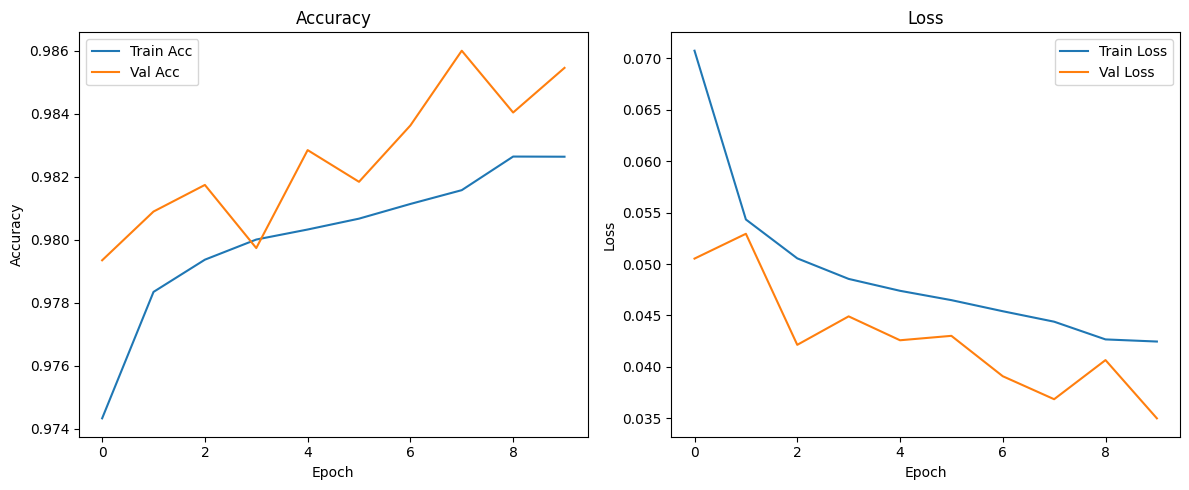

In [39]:
import matplotlib.pyplot as plt
import timeit

# Train the Model
start_time = timeit.default_timer()
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_val, y_val),
    verbose=1
)
end_time = timeit.default_timer()
print(f"Training time: {end_time - start_time:.2f} seconds")


# Plot Accuracy and Loss
plt.figure(figsize=(12,5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



# Evaluate 1D CNN Malware Detection Results

In [40]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Get predictions of x_test dataset
threshold = 0.5 #0.09 gave only 773 fn
print(f"threshold: {threshold}")
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > threshold).astype(int).flatten()  # Boolean statmenent that flattens y_pred to 0 (False) if the CNN's prediction is bigger than the threshold

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Optional: print as table
print("Confusion Matrix:")
print(cm)

# Detailed breakdown
tn, fp, fn, tp = cm.ravel()
print(f"\nTrue Negatives (Benign correctly classified): {tn}")
print(f"False Positives (Benign misclassified as malware): {fp}")
print(f"False Negatives (Malware missed): {fn}")
print(f"True Positives (Malware correctly identified): {tp}")

# Accuracy scores
print("Accuracy:")
print("sklearn Accuracy:", accuracy_score(y_test, y_pred))
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)# Evaluate model with test set
print(f"model.evaluate Accuracy: {test_acc:.4f}")
print(f"Confusion Matrix Accuracy: {(tp + tn) / (tp + tn + fp + fn)}")
print(f"{(tp/(tp+fn))*100:.4f}% of malware identified")
print(f"{(fp/(fp+tn))*100:.4f}% of benign traffic incorrectly identified")

# Classification report (accuracy, precision, recall, F1)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Benign", "Malicious"]))

threshold: 0.5
23633/23633 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step
Confusion Matrix:
[[623952   4566]
 [  6815 120893]]

True Negatives (Benign correctly classified): 623952
False Positives (Benign misclassified as malware): 4566
False Negatives (Malware missed): 6815
True Positives (Malware correctly identified): 120893
Accuracy:
sklearn Accuracy: 0.9849502661902658
model.evaluate Accuracy: 0.9850
Confusion Matrix Accuracy: 0.9849502661902658
94.6636% of malware identified
0.7265 of benign traffic incorrectly identified

Classification Report:
              precision    recall  f1-score   support

      Benign       0.99      0.99      0.99    628518
   Malicious       0.96      0.95      0.96    127708

    accuracy                           0.98    756226
   macro avg       0.98      0.97      0.97    756226
weighted avg       0.98      0.98      0.98    756226



#Plot of CNN's predictions vs. actual labels

/tmp/ipython-input-445008161.py:27: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


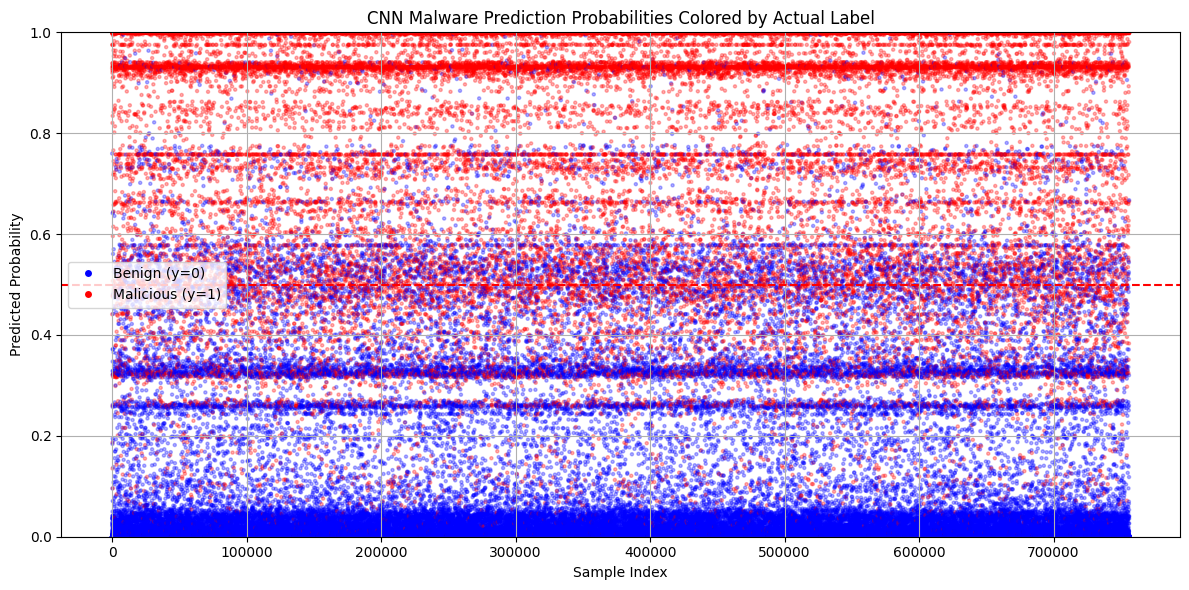

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# --- Plot CNN Prediction Probabilities ---
# Map actual labels to colors: red = malicious (1), blue = benign (0)
colors = np.where(y_test == 1, 'red', 'blue')

# X-axis = sample index
x_vals = np.arange(len(y_pred_probs))

# Plot predictions with color by actual label
plt.figure(figsize=(12, 6))
plt.scatter(x_vals, y_pred_probs, c=colors, alpha=0.3, s=5)
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold = 0.2')

# Labels and styling
plt.ylim([0, 1])
plt.xlabel("Sample Index")
plt.ylabel("Predicted Probability")
plt.title("CNN Malware Prediction Probabilities Colored by Actual Label")
custom_lines = [
    plt.Line2D([0], [0], marker='o', color='w', label='Benign (y=0)', markerfacecolor='blue', markersize=6),
    plt.Line2D([0], [0], marker='o', color='w', label='Malicious (y=1)', markerfacecolor='red', markersize=6)
]
plt.legend(handles=custom_lines)
plt.grid(True)
plt.tight_layout()
plt.show()

/tmp/ipython-input-2269122754.py:36: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


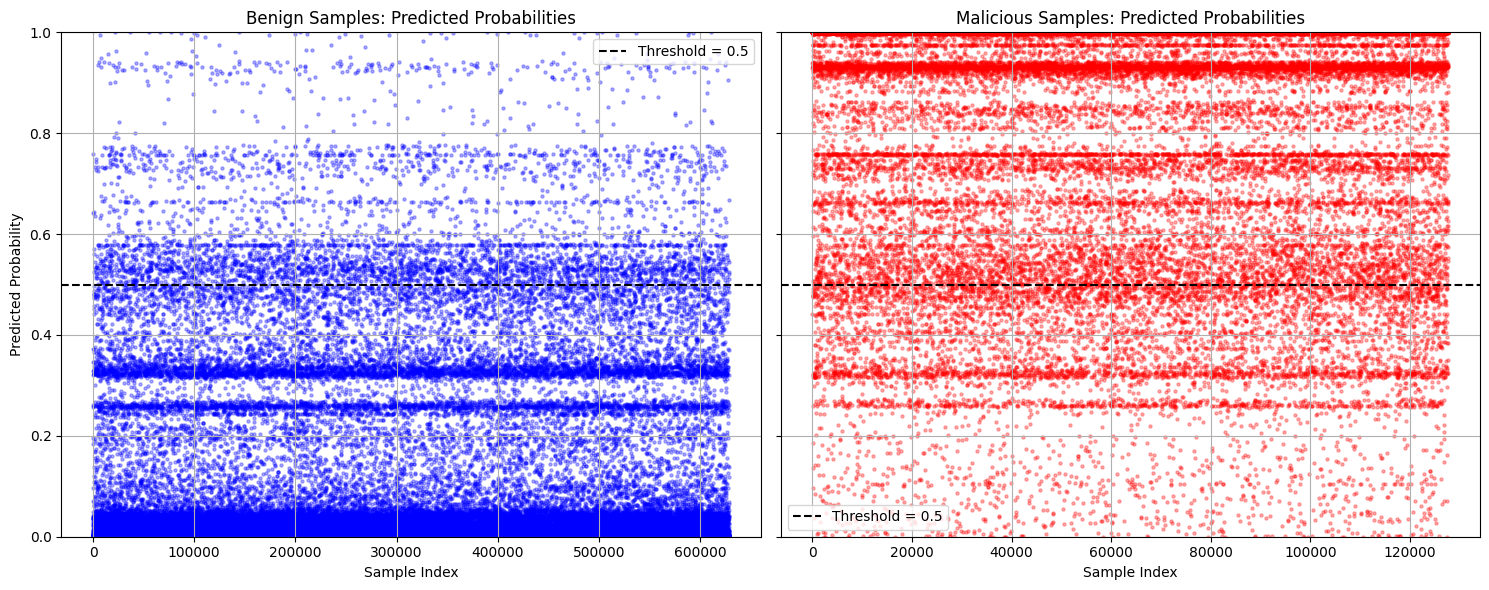

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Separate predictions based on actual labels
benign_indices = np.where(y_test == 0)[0]
malicious_indices = np.where(y_test == 1)[0]

benign_probs = y_pred_probs[benign_indices]
malicious_probs = y_pred_probs[malicious_indices]

benign_x = np.arange(len(benign_probs))
malicious_x = np.arange(len(malicious_probs))

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Plot for Benign samples
axes[0].scatter(benign_x, benign_probs, c='blue', alpha=0.3, s=5)
axes[0].axhline(y=threshold, color='black', linestyle='--', linewidth=1.5, label=f'Threshold = {threshold}')
axes[0].set_ylim([0, 1])
axes[0].set_xlabel("Sample Index")
axes[0].set_ylabel("Predicted Probability")
axes[0].set_title("Benign Samples: Predicted Probabilities")
axes[0].legend()
axes[0].grid(True)

# Plot for Malicious samples
axes[1].scatter(malicious_x, malicious_probs, c='red', alpha=0.3, s=5)
axes[1].axhline(y=threshold, color='black', linestyle='--', linewidth=1.5, label=f'Threshold = {threshold}')
axes[1].set_ylim([0, 1])
axes[1].set_xlabel("Sample Index")
axes[1].set_title("Malicious Samples: Predicted Probabilities")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# 1D CNN Quant model

In [43]:
import tensorflow as tf
import numpy as np
import os
from sklearn.utils import shuffle

# --- STEP 1: Balance the sample set to 40% benign, 60% malware ---
def balance_sample_data(X_train, y_train, benign_ratio=0.4):
    benign_X = X_train[y_train == 0]
    malware_X = X_train[y_train == 1]

    total = min(len(benign_X) + len(benign_X), 100000)
    benign_n = int(benign_ratio * total)
    malware_n = total - benign_n

    benign_X_sampled = benign_X[np.random.choice(len(benign_X), benign_n)]
    malware_X_sampled = malware_X[np.random.choice(len(malware_X), malware_n)] #ISSUE?

    X_bal = np.vstack((benign_X_sampled, malware_X_sampled))
    y_bal = np.array([0]*benign_n + [1]*malware_n)

    return shuffle(X_bal, y_bal, random_state=42)

# Apply balancing to training data
X_sample, y_sample = balance_sample_data(X_train, y_train, benign_ratio=0.4)

# Ensure 1D shape (samples, timesteps, 1)
X_sample = X_sample.reshape((X_sample.shape[0], X_sample.shape[1], 1))

# --- STEP 2: Define representative dataset for quantization ---
def representative_dataset():
    for i in range(1000):
        index = np.random.randint(0, X_sample.shape[0]) #randomise choices from X_sample data to get a range of diverse samples (not just the first 1000)
        yield [X_sample[index:index+1].astype(np.float32)]

# --- STEP 3: Quantization function ---
def converter_quantization_model(model, model_name):
    os.makedirs('./models', exist_ok=True)

    # Save float32 optimized model
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.target_spec.supported_types = [tf.float32]
    converter.representative_dataset = representative_dataset
    tflite_model_float32 = converter.convert()
    with open(model_name + '_quant_float32.tflite', 'wb') as f:
        f.write(tflite_model_float32)

    # Save int8 quantized model
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.target_spec.supported_types = [tf.int8]
    converter.inference_input_type = tf.int8
    converter.inference_output_type = tf.int8
    converter.representative_dataset = representative_dataset
    tflite_model_int8 = converter.convert()
    with open(model_name + '_quant_int8.tflite', 'wb') as f:
        f.write(tflite_model_int8)

# --- STEP 4: Apply conversion ---
converter_quantization_model(CNN_model, './models/1Dcnn')


Saved artifact at '/tmp/tmphd5mn9j1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 52, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  138670468610576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138670468611536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138670192921296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138670192921680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138670192919568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138670192920720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138670192920336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138670192922832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138670192918608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138670192922640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138670192921104: Ten

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


#Evaluate int8 1D CNN

In [45]:
from tensorflow.lite.python.interpreter import Interpreter
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import time


def evaluate_tflite_model(tflite_path, X_test, y_test):
    #Load and Prepare TFLite Interpreter
    interpreter = Interpreter(model_path=tflite_path)
    interpreter.allocate_tensors()

    #Fetch input & output Tensor Details from the TensorFlow Lite Interpreter after the model is loaded and memory for its tensors is allocated.
    input_details = interpreter.get_input_details() #Input tensor: shape, dtype, index.
    output_details = interpreter.get_output_details() #Output tensor: shape, dtype, index, quantisation.

    #Store the tensor indices and data types for input/output
    input_index = input_details[0]['index']
    output_index = output_details[0]['index']
    input_dtype = input_details[0]['dtype']
    output_dtype = output_details[0]['dtype']

    # Calculate Quantization Threshold
    output_scale, output_zero_point = output_details[0]['quantization']#Get quantization parameters for the output
    if output_dtype == np.int8:
        quantized_threshold = int(round(0.5 / output_scale + output_zero_point)) #Computes the int8 value that corresponds to 0.5 — the usual binary classification threshold for float.

    #Initializes empty lists to store predictions and timing
    predictions = []
    processing_times = []

    for i in range(len(X_test)):
        #input_data = np.expand_dims(X_test[i], axis=0).astype(input_dtype)#Prepare Input Tensor and Run Inference
        input_data = np.expand_dims(X_test[i], axis=0)

        if input_dtype == np.int8:
            input_scale, input_zero_point = input_details[0]['quantization']
            input_data = (input_data / input_scale + input_zero_point).astype(np.int8)
        else:
            input_data = input_data.astype(input_dtype)

        start_time = time.time()
        interpreter.set_tensor(input_index, input_data) #Loads input into the interpreter.
        interpreter.invoke() #Execute the model
        output = interpreter.get_tensor(output_index) #Gets the output tensor.
        processing_times.append(time.time() - start_time)

        # Handle prediction thresholding for float and int8 models
        if output_dtype == np.float32:
            pred = (output[0][0] > 0.5).astype(int)
        elif output_dtype == np.int8:
            pred = (output[0][0] > quantized_threshold).astype(int) #If int8, compare against precomputed quantized threshold
        else:
            raise ValueError(f"Unsupported output dtype: {output_dtype}")

        predictions.append(pred)

    #Evaluate Accuracy and Confusion Matrix
    acc = accuracy_score(y_test, predictions)
    cm = confusion_matrix(y_test, predictions)

    print(f"{tflite_path} Accuracy: {acc:.4f}")
    print(f"Avg inference time: {np.mean(processing_times)*1000:.2f} ms/sample")
    print("Confusion Matrix:")
    print(cm)


    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        print(f"{(tp/(tp+fn))*100:.4f}% of malware identified")
        print(f"\nTrue Negatives (Benign correctly classified): {tn}")
        print(f"False Positives (Benign misclassified as malware): {fp}")
        print(f"False Negatives (Malware missed): {fn}")
        print(f"True Positives (Malware correctly identified): {tp}")
    else:
        print("\nWarning: Confusion matrix is not 2x2 — check labels.")

# Execute evaluation function:
evaluate_tflite_model("./models/1Dcnn_quant_float32.tflite", X_test, y_test)
evaluate_tflite_model("./models/1Dcnn_quant_int8.tflite", X_test, y_test)

./models/1Dcnn_quant_float32.tflite Accuracy: 0.9389
Avg inference time: 0.02 ms/sample
Confusion Matrix:
[[628062    456]
 [ 45771  81937]]
64.1596% of malware identified

True Negatives (Benign correctly classified): 628062
False Positives (Benign misclassified as malware): 456
False Negatives (Malware missed): 45771
True Positives (Malware correctly identified): 81937
./models/1Dcnn_quant_int8.tflite Accuracy: 0.9378
Avg inference time: 0.01 ms/sample
Confusion Matrix:
[[628178    340]
 [ 46681  81027]]
63.4471% of malware identified

True Negatives (Benign correctly classified): 628178
False Positives (Benign misclassified as malware): 340
False Negatives (Malware missed): 46681
True Positives (Malware correctly identified): 81027
